<h1>Project 1</h1>
<h2>The bank algorithm</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pydot
import uuid 
from itertools import combinations
from itertools import permutations


<h2> Check Solution </h2>

In [2]:
#check solution
import math

def distance(x1, y1, x2, y2):
    return math.hypot(x2 - x1, y2 - y1)

def check_solution(travel_list, df, speed=30.):
    """
    Check a bank robber algorithm solution
    
    input:
    ------
    travel_list: a list of integers
        Your solution to the bank robber problem
        Bank IDs are row indeces into the df passed
    df: pd.DataFrame
        The algorithm input formatted dataframe 
        (id,x_coordinate,y_coordinate,money,time (hr))
    speed: float
        The km/h speed of travel
    """
    t_remaining = 24.
    score = 0.
    assert len(travel_list) == len(set(travel_list)), (
        "Your travel list must have unique IDs!"
    )
    prev = travel_list[0]
    for e in travel_list:
        row = df.iloc[e]
        score += row['money']
        t_remaining -= row['time (hr)']
        dist = distance(
            row['x_coordinate'], row['y_coordinate'],
            df.iloc[prev]['x_coordinate'],
            df.iloc[prev]['y_coordinate'],
        )
        t_remaining -= dist / speed
        prev = e
    assert t_remaining >= 0, (
        f"Used more than 24h! Time left: {t_remaining}"
    )
    # still gotta get to (0, 0)
    dist = distance(row['x_coordinate'],row['y_coordinate'],0,0)
    final_t = t_remaining - (dist / speed)
    assert final_t >= 0, (
        f"Not enough time to get to helicopter!\n"
        f"Time left after last bank: {t_remaining}\n"
        f"Distance to (0,0) helipad: {dist}\n"
    )
    print(f"Time Remaining: {final_t}")
    return score

<h2> Solution </h2>
<h3> Greedy Algorithm</h3>

In [3]:
SPEED = 30 #km/hr

In [4]:
df_original = pd.read_csv('bank_data.csv')

In [5]:
df0 = df_original.copy()
df0['money/time'] = df0['money']/df0['time (hr)']


In [6]:
df0 = df0.sort_values('money/time', ascending=False)
df_temp1 = pd.DataFrame({'id': [-1], 'x_coordinate':[0], 'y_coordinate':[0], 'money':[0], 'time (hr)':[0]})
df0 = df_temp1.append(df0).reset_index(drop=True)
df0['cum_sum_money'] = df0['money'].cumsum()
df0['cum_sum_time'] = df0['time (hr)'].cumsum()
df0 = df0[df0['cum_sum_time'] <= 24]
df0=df0.set_index('id')
possible_banks = df0.index

In [7]:
cbns = list(combinations(possible_banks,2))

In [8]:
d_cbns = {'combinations': cbns}
df_cbns = pd.DataFrame(data = d_cbns)
df_cbns['b1'] = df_cbns['combinations'].map(lambda x: x[0])
df_cbns['b2'] = df_cbns['combinations'].map(lambda x: x[1])
df_cbns = df_cbns.drop('combinations', axis=1)
df_temp2 = pd.DataFrame({'b1': df_cbns['b2'],'b2': df_cbns['b1'] })
df_cbns = df_cbns.append(df_temp2)
df_cbns['b_id'] = df_cbns['b1'].astype(str)+'_'+df_cbns['b2'].astype(str)
df_cbns = df_cbns.reset_index(drop=True)

In [9]:
df_cbns['x_coordinate1'] = df_cbns['b1'].map(df0['x_coordinate']) #Km
df_cbns['y_coordinate1'] = df_cbns['b1'].map(df0['y_coordinate']) #Km
df_cbns['x_coordinate2'] = df_cbns['b2'].map(df0['x_coordinate']) #Km
df_cbns['y_coordinate2'] = df_cbns['b2'].map(df0['y_coordinate']) #Km
df_cbns['distance'] =  np.sqrt((df_cbns['x_coordinate2']-df_cbns['x_coordinate1'])**2 + (df_cbns['y_coordinate2']-df_cbns['y_coordinate1'])**2) #Km
df_cbns['travel_time'] = df_cbns['distance']/SPEED #Hr
df_cbns['robbing_time2'] = df_cbns['b2'].map(df0['time (hr)']) #hr
df_cbns['total_time2'] = df_cbns['travel_time']+df_cbns['robbing_time2'] #Hr
df_cbns['money2'] = df_cbns['b2'].map(df0['money']) #$
df_cbns['money2/total_time2'] = df_cbns['money2']/df_cbns['total_time2'] #$/hr



<h2>Solution which generates the most money</h2>
<h3>1- Greedy algorithm which considers travelling to the next bank which is closest in term of travelling time</h3>


In [10]:
def banks_3(data):
    '''
    Greedy Algorithm
    Function which takes as input a dataframe which contains data on the most promising banks to steal in terms of money 
    over time. This particular algorithm starts at (0,0) and selects the next closest banks among the most promising banks.

    Input :
    data: dataframe which contains the most promising banks to steal
    '''
    
    df = data.copy()
    time = 0
    money = 0
    current_bank = -1
    df = df[df['b2']!=current_bank]
    banks = []
    while (time <= 24):
        df_temp = df[df['b1']==current_bank]
        min_time = np.min(df_temp['travel_time'])
        next_bank = df_temp[df_temp['travel_time']==min_time]['b2'].values[0]
        time += df_temp[df_temp['travel_time']==min_time]['total_time2'].values[0]       
        df = df[df['b2']!=next_bank]
        current_bank = next_bank
        
        if time<=24:
            banks.append(next_bank)
    return banks[::-1]

In [11]:
travel_list3 = banks_3(df_cbns)
check_solution(travel_list3, df_original, speed=30.) 

Time Remaining: 0.17083449639037573


14234800.0

<h2>Solutions which generate less money</h2>
<h3>1- Greedy algorithm which condsiders travelling to next bank with greatest ratio of money/time</h3>
<h3>2- Greedy algorithm which includes a common nearest banks to the current bank and to the next most promising bank</h3>

In [12]:
def banks_1(data):
    '''
    Greedy Algorithm
    Function which takes as input a dataframe which contains data on the most promising banks to steal in terms of money 
    over time. This particular algorithm starts at (0,0) and travels to the next bank that has the greatest ratio of money
    over time.

    Input :
    data: dataframe which contains the most promising banks to steal
    '''
    
    df = data.copy()
    time = 0
    money = 0
    current_bank = -1
    banks = []
    while (time <= 24):
        df_temp = df[df['b1']==current_bank]
        max_money_time=df_temp['money2/total_time2'].max()
        next_bank = df_temp[df_temp['money2/total_time2']==max_money_time]['b2'].values[0]
        time += df_temp[df_temp['money2/total_time2']==max_money_time]['total_time2'].values[0]
        df = df[df['b2']!=next_bank]
        current_bank = next_bank
        if time<=24:
            banks.append(next_bank)
    return banks[::-1]
        
        

In [13]:
#Test
travel_list1 = banks_1(df_cbns)
check_solution(travel_list1, df_original, speed=30.) 

Time Remaining: 0.029078042295429776


14204100.0

In [14]:
def banks_1_1(data):
    '''
    Greedy algorithm which was modified to include a common closest bank to the current bank and to the next most promising
    bank.
    '''
    
    df = data.copy()
    time = 0
    money = 0
    current_bank = -1
    banks = []
    while (time <= 24):
        df_temp = df[df['b1']==current_bank]
        max_money_time=df_temp['money2/total_time2'].max()
        next_bank = df_temp[df_temp['money2/total_time2']==max_money_time]['b2'].values[0]
        
        #Common nearest neighbor to the current bank and next promisiing bank
        nearest_b1 = df_temp.sort_values('money2/total_time2', ascending= False)
        nearest_b1 = nearest_b1[nearest_b1['b2']!=next_bank][0:2]['b2']
        nearest_b2 = df[df['b1']==next_bank].sort_values('money2/total_time2', ascending= False)
        nearest_b2 = nearest_b2[nearest_b2['b2']!=current_bank][0:2]['b2']
        common_neighbors = list(set(nearest_b1).intersection(set(nearest_b2)))
        
        if len(common_neighbors)>0:
            common_neighbor = common_neighbors.pop(0)
            time += df_temp[df_temp['b2']==common_neighbor]['total_time2'].values[0]
            if time<=24:
                banks.append(common_neighbor)
                df = df[(df['b2']!=common_neighbor)]
            time += df[(df['b1']==common_neighbor) & (df['b2']==next_bank)]['total_time2'].values[0]
            if time<=24:
                banks.append(next_bank)
                df = df[df['b2']!=next_bank]   
        else:
            time += df_temp[df_temp['money2/total_time2']==max_money_time]['total_time2'].values[0]
            df = df[df['b2']!=next_bank]
            if time<=24:
                banks.append(next_bank)
        current_bank = next_bank
    return banks
        

In [15]:
travel_list1_1 = banks_1_1(df_cbns)
check_solution(travel_list1_1[::-1], df_original, speed=30.) 

Time Remaining: 0.14607078677223945


12731200.0

<h2>Solution which takes more than 3 minutes to run but which is able to find a sequence of banks that generates more money within 24 hours</h2>
<h3>1-Greedy algorithm which loops through a list of best possible banks as a starting point and compares various  </h3>

In [16]:
# def banks_2(data, banks_list, df_initial):
#     data = data[data['b2']!=-1]
#     max_money_s= 0
#     best_banks = None
#     i=0
#     for initial_bank in banks_list:
#         current_bank = initial_bank
#         banks = []
#         time = 0
#         df = data.copy()
        
#         while (time <= 24):
#             df_temp = df[df['b1']==current_bank]
#             min_time= np.min(df_temp['travel_time'])
#             next_bank = df_temp[df_temp['travel_time']==min_time]['b2'].values[0]
#             time += df_temp[df_temp['travel_time']==min_time]['total_time2'].values[0]
#             time_remaining = 24-time
#             time_left_to_escape = df_cbns[(df_cbns['b1']== next_bank) & (df_cbns['b2']==-1)]['travel_time'].values[0]
#             df = df[df['b2']!=next_bank]
#             current_bank = next_bank
#             #Verify if time is less than 24 hours and remaining time is sufficient to escape to helipad
#             if (time<=24) and (time_left_to_escape<=time_remaining):
#                 banks.append(next_bank)
                
#         total_money_s = df_initial[df_initial.index.isin(banks)]['money'].sum()
#         if total_money_s > max_money_s:
#             max_money_s = total_money_s
#             best_banks = banks
#         i+=1
#     return best_banks, max_money_s
        



In [17]:
travel_list2, money_s = banks_2(df_cbns, possible_banks, df_original)
check_solution(travel_list2, df_original, speed=30.) 

Time Remaining: 0.022152127686968587


14439100.0

<h2>Work in progress</h2>
<h3>Solution consists of creating a tree structure in networkx which essentially selects at the current bank the next n possible banks and makes use of the built-in algorithms of the networkx package to find the total amount of money for each of the branches of the tree (i.e. all possible sequences of banks).</h3>

The current problems are the following:
- The code can generate a tree-like structure in networkx when variable "time" in function called "create_tree_structure"  is less than an 1 hour. Then a problem occurs due maybe to stack overflow. A more efficient problem would need to be developed. 
- Need to convert unique ids back to bank ids
- Need to return the root_node_uuid


In [18]:
def find_next_candidates(n, current_location_id, data):
    '''
    Function which returns the n next candidates which have the greatest money/time ratio which are closest to their
    current location. If there are no other candidates candidates within the radius returns the n next closest candidates 
    outside of the radius.
    
    Input:
    n: number of candidates 
    current_location_id = id of current location
    data: dataframe with data on the best candidates in the entire space
    
    '''
    cur_loc_id = current_location_id
    df = data.copy()
    dft = df[df['b1']==cur_loc_id] 
    dft = dft.sort_values('distance')
    dft = dft[:n]
    return dft

next_candidates = find_next_candidates(5,-1, df_cbns)


    

99b9ee1e-69a0-4284-9ab1-cca84e1fafec


C:\Users\education\anaconda3\lib\site-packages\networkx\drawing\layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


True

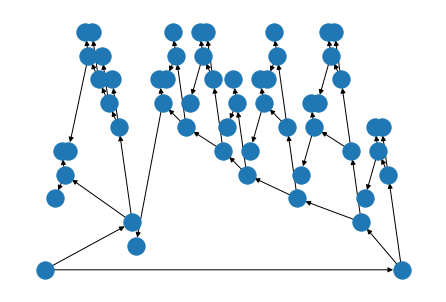

In [19]:

def create_tree_structure(data,n):
    '''
    Function which create a tree-like structure in networkx so that the builtin function can be used to find the 
    total amount of money for each potential sequence of banks.
    
    Input :
    data = dataframe with the best possible banks in the entire space
    n = number of next best possible bank to consider at the current bank
    '''
    initial_loc_id = -1 #initial_location_id at (0,0) | id -1 corresponds to location (0,0)
    root_initial = True
    G = nx.DiGraph()
    df = data.copy()
    initial_time = 0
    
    def tree_recursion(n, root, cur_loc_id, cur_uuid, time, data_tree, graph):
        df = data_tree.copy()
        #Base case
        if time>=0.5:
#             print(f'reached {time} hours')
            return time

        #Recursive case
    
        #If the current location is the inital point
        if root == True:
            initial_money = df[df['b2']==cur_loc_id]['money2'][:1].values[0]
            root_node_uuid = str(uuid.uuid4())
            print(root_node_uuid)
            graph.add_node(root_node_uuid, money = initial_money)
            df = df[df['b2']!=-1]
        
        #Find the n next best possible banks
        df_cnds = find_next_candidates(n, cur_loc_id, df)
        next_candidates_id = list(df_cnds['b_id'])
        next_candidates_b2 = list(df_cnds['b2'])

        for i, nxt_cnd_id in enumerate(next_candidates_id):
            #Store in variable money at the next bank and total time (Time to traval + time at the bank)
            money = df_cnds[df_cnds['b_id'] == nxt_cnd_id]['money2'].values[0]
            total_time = df_cnds[df_cnds['b_id'] == nxt_cnd_id]['total_time2'].values[0]
            
            #Create a unique id for the bank to store in networkx
            next_cdn_uuid = str(uuid.uuid4())
            if root == True:
                cur_cdn_uuid = root_node_uuid
            else:
                cur_cdn_uuid = cur_uuid
            #Store the node and edges in graph
            graph.add_node(cur_cdn_uuid, money = money)
            graph.add_edge(cur_cdn_uuid, next_cdn_uuid, money = money,time = total_time)
            
            #Update current candidate uuid to be the next_cdn_uuid
            cur_cdn_uuid = next_cdn_uuid
            
            #Update the time so that it equals travelling time and time spent at the bank
            time += total_time
            
            #Update the dataframe in order to remove the possibility of coming back to the same bank
            dft = df[df['b2']!=next_candidates_b2[i]]
            
            #Call recursive function with updated variables
            tree_recursion(n, False, next_candidates_b2[i], cur_cdn_uuid, time, dft, graph)

            
    tree_recursion(n, root_initial, initial_loc_id,str(initial_loc_id), initial_time, df, G)
    return G
#     nx.draw(G, with_labels = True)
#     print(G.nodes.data())

    

tree = create_tree_structure(df_cbns, 2) 
nx.draw_planar(tree)
nx.is_tree(tree)



In [22]:
# root ='99b9ee1e-69a0-4284-9ab1-cca84e1fafec'
# for node in tree:
#     if tree.out_degree(node)==0:
#         time, path = nx.multi_source_dijkstra(tree, {root},node, weight = 'time')
#         money, path = nx.multi_source_dijkstra(tree, {root},node, weight = 'money')
#         print(time, money)
#         print(path)
#         print('\n')

0.5051886467426987 412000
['99b9ee1e-69a0-4284-9ab1-cca84e1fafec', '5c5298eb-1977-4295-82b6-6c738ae174b5', 'e6e146f9-cbb6-4cba-9a22-fab9b1a42e23', 'ee841eb7-6a27-4d60-806a-623a77ee3867', 'fd39b6e5-c52f-422c-9fba-18cadcaa8162', '1f7affae-eb93-4947-b91f-aff3cb3047b6', 'cbe947fb-8320-46d9-8d87-41798afa144b', 'd5873d23-37b6-4e65-b244-5f177b046f72', 'b49b79d8-844c-4eaa-bd61-0ac53941a423']


0.5437193250138834 387100
['99b9ee1e-69a0-4284-9ab1-cca84e1fafec', '5c5298eb-1977-4295-82b6-6c738ae174b5', 'e6e146f9-cbb6-4cba-9a22-fab9b1a42e23', 'ee841eb7-6a27-4d60-806a-623a77ee3867', 'fd39b6e5-c52f-422c-9fba-18cadcaa8162', '1f7affae-eb93-4947-b91f-aff3cb3047b6', 'cbe947fb-8320-46d9-8d87-41798afa144b', 'd5873d23-37b6-4e65-b244-5f177b046f72', 'a008a691-d265-4d9c-9df2-cb72575ace22']


0.489195201573554 390700
['99b9ee1e-69a0-4284-9ab1-cca84e1fafec', '5c5298eb-1977-4295-82b6-6c738ae174b5', 'e6e146f9-cbb6-4cba-9a22-fab9b1a42e23', 'ee841eb7-6a27-4d60-806a-623a77ee3867', 'fd39b6e5-c52f-422c-9fba-18cadcaa816